In [4]:
#pip install git+https://github.com/simai-ml/MAPIE

  Cloning https://github.com/simai-ml/MAPIE to /tmp/pip-req-build-20_cz_5l
  Running command git clone -q https://github.com/simai-ml/MAPIE /tmp/pip-req-build-20_cz_5l
  Resolved https://github.com/simai-ml/MAPIE to commit 462207aae5bde9244aa03e005adacc2fe66e14a4
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [1]:
from mapie.regression import MapieRegressor

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_columns',None)
import datetime as dt

#from sklearn.multioutput import MultiOutputRegressor
import xgboost as xgb
from sklearn import metrics

from sklearn.metrics import r2_score,mean_squared_error
import math
import time

import warnings
warnings.filterwarnings('ignore')


In [3]:
train_data = pd.read_csv('train_data_E2E.csv')
test_data = pd.read_csv('test_data_E2E.csv')

print(train_data.shape,test_data.shape)

(47228, 64) (11808, 64)


In [4]:
train_data['PROMISED_DATE_FIRST'] = pd.to_datetime(train_data['PROMISED_DATE_FIRST'])
train_data['NEED_DATE_']  = pd.to_datetime(train_data['NEED_DATE_'])
train_data['NEED_DATE_numeric'] =  train_data['NEED_DATE_'].map(dt.datetime.toordinal)
train_data['PROMISED_DATE_FIRST_numeric']=train_data['PROMISED_DATE_FIRST'].map(dt.datetime.toordinal)
train_data.drop(['PROMISED_DATE_FIRST','NEED_DATE_'],axis=1,inplace=True)

test_data['PROMISED_DATE_FIRST'] = pd.to_datetime(test_data['PROMISED_DATE_FIRST'])
test_data['NEED_DATE_']  = pd.to_datetime(test_data['NEED_DATE_'])
test_data['NEED_DATE_numeric'] =  test_data['NEED_DATE_'].map(dt.datetime.toordinal)
test_data['PROMISED_DATE_FIRST_numeric']=test_data['PROMISED_DATE_FIRST'].map(dt.datetime.toordinal)
test_data.drop(['PROMISED_DATE_FIRST','NEED_DATE_'],axis=1,inplace=True)

In [5]:
# y varaible is  'PROMISED_DATE_FIRST_numeric' , 

train_y = train_data.pop('PROMISED_DATE_FIRST_numeric')
train_X = train_data
test_y = test_data.pop('PROMISED_DATE_FIRST_numeric')
test_X = test_data
print(test_y.shape,test_X.shape)

(11808,) (11808, 63)


In [7]:
# Try a simple XGB model
other_params={'learning_rate':0.1,'n_estimators':300,'max_depth':5,'min_child_weight':1,'subsample':0.8,'colsample_bytree':0.8}

regressor =xgb.XGBRegressor(objective='reg:squarederror',**other_params)

xgb_regressor =regressor.fit(train_X, train_y)
predictions_promised_date = regressor.predict(test_X)

# promised first date 28
# diff beween recived and booked date
print('Root_mean_squared_error_test set_',math.sqrt(mean_squared_error(test_y,predictions_promised_date)))
print('R2 Score_test set_xgb',r2_score(test_y,predictions_promised_date))

Root_mean_squared_error_test set_ 28.60031696603506
R2 Score_test set_xgb 0.9620073102812062


In [10]:
results_df = pd.DataFrame({'test_y':test_y,'predictions_promised_date':predictions_promised_date.astype(int)})
results_df['test_y_date'] = results_df['test_y'].apply(dt.datetime.fromordinal)
results_df['predictions_promised_date_'] = results_df['predictions_promised_date'].apply(dt.datetime.fromordinal)

results_df['diff_'] = abs((results_df['test_y_date'] - results_df['predictions_promised_date_']).dt.days)

results_df['diff_'].describe()

count    11808.000000
mean        12.271850
std         25.842149
min          0.000000
25%          3.000000
50%          6.000000
75%         13.000000
max        845.000000
Name: diff_, dtype: float64

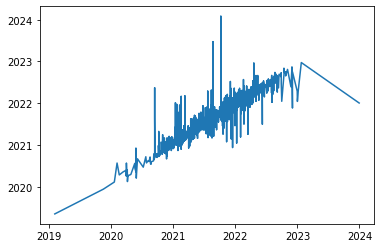

In [11]:
results_df = results_df.sort_values('test_y_date')
plt.plot(results_df['test_y_date'],results_df['predictions_promised_date_'])

In [12]:
print('accuracy 3days', np.sum( np.abs((results_df['predictions_promised_date_']- results_df['test_y_date']).dt.days) <= 3) / results_df['test_y_date'].shape[0])
print('accuracy 6days', np.sum( np.abs((results_df['predictions_promised_date_']- results_df['test_y_date']).dt.days) <= 6) / results_df['test_y_date'].shape[0])
print('accuracy 10days', np.sum( np.abs((results_df['predictions_promised_date_']- results_df['test_y_date']).dt.days) <= 10) / results_df['test_y_date'].shape[0])
print('accuracy 20days', np.sum( np.abs((results_df['predictions_promised_date_']- results_df['test_y_date']).dt.days) <= 20) / results_df['test_y_date'].shape[0])
print('accuracy 30days', np.sum( np.abs((results_df['predictions_promised_date_']- results_df['test_y_date']).dt.days) <= 30) / results_df['test_y_date'].shape[0])
print('accuracy 90days', np.sum( np.abs((results_df['predictions_promised_date_']- results_df['test_y_date']).dt.days) <= 90) / results_df['test_y_date'].shape[0])

print('************************************************************************************************')
print('accuracy unpaired 30days', np.sum( ( (results_df['test_y_date'] - results_df['predictions_promised_date_']).dt.days) <= 30) / results_df['test_y_date'].shape[0])

accuracy 3days 0.3170731707317073
accuracy 6days 0.5226117886178862
accuracy 10days 0.6898712737127372
accuracy 20days 0.8611957994579946
accuracy 30days 0.9209857723577236
accuracy 90days 0.986449864498645
************************************************************************************************
accuracy unpaired 30days 0.9654471544715447


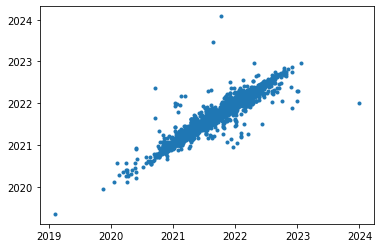

In [13]:
results_df = results_df.reset_index(drop=True)
plt.plot(results_df['test_y_date'], results_df['predictions_promised_date_'],'.')
plt.show()

In [ ]:
# feature importance from xgb

<AxesSubplot:>

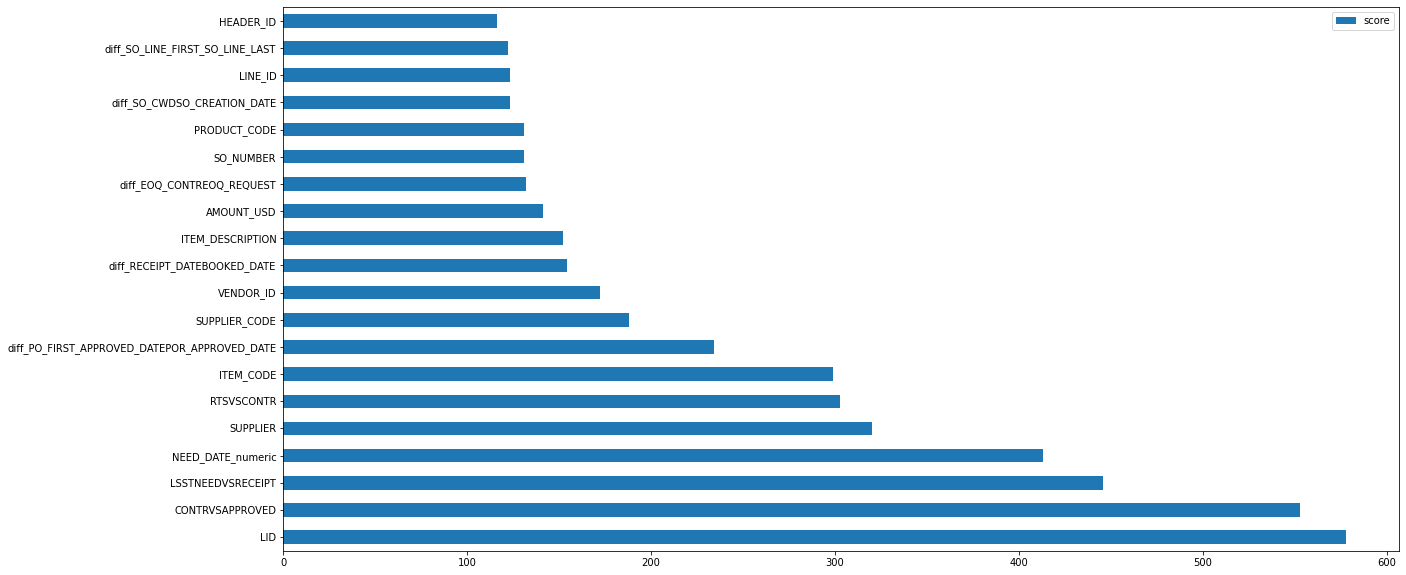

In [14]:
feature_important_wt = regressor.get_booster().get_score(importance_type='weight')
keys = list(feature_important_wt.keys())
values = list(feature_important_wt.values())

top_features = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
top_features.nlargest(20, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 20 features

<AxesSubplot:>

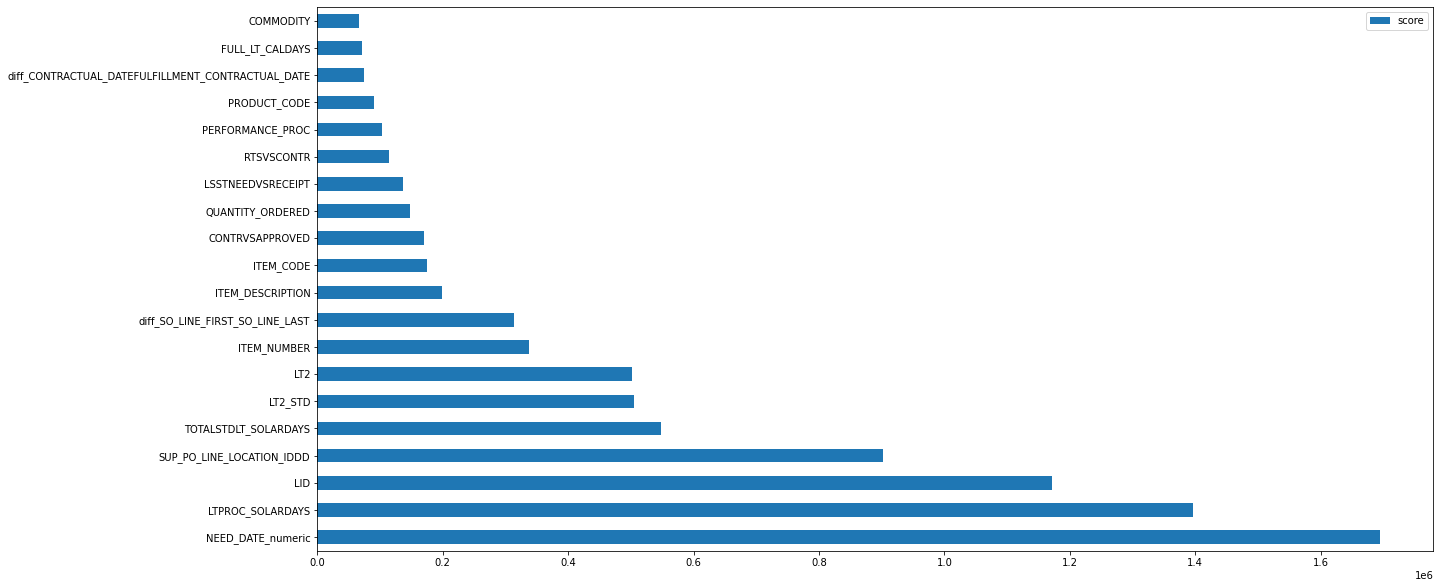

In [15]:
feature_important_gain = regressor.get_booster().get_score(importance_type='gain')
keys = list(feature_important_gain.keys())
values = list(feature_important_gain.values())

top_features = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
top_features.nlargest(20, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 20 features

In [ ]:
# with mapie

In [9]:
# with MAPIE
model_mapie = MapieRegressor(xgb_regressor) 
# Fit model
model_mapie.fit(train_X, train_y)

MapieRegressor(estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                      callbacks=None, colsample_bylevel=1,
                                      colsample_bynode=1, colsample_bytree=0.8,
                                      early_stopping_rounds=None,
                                      enable_categorical=False,
                                      eval_metric=None, gamma=0, gpu_id=-1,
                                      grow_policy='depthwise',
                                      importance_type=None,
                                      interaction_constraints='',
                                      learning_rate=0.1, max_bin=256,
                                      max_cat_to_onehot=4, max_delta_step=0,
                                      max_depth=5, max_leaves=0,
                                      min_child_weight=1, missing=nan,
                                      monotone_constraints='()',
                                      n_estimators=300, n_jobs=0,
                                      num_parallel_tree=1, predictor='auto',
                                      random_state=0, reg_alpha=0, reg_lambda=1, ...))

In [ ]:
df_y = df_y.values
    
    df_yhat, y_pis = model.predict(df_x, alpha=alpha)

    print('mean', np.mean(df_y))
    print('MAE', mean_absolute_error(df_yhat, df_y))
    print('R2', r2_score(df_yhat, df_y))

In [ ]:
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np 
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

def _eval(model, test_X, test_y, alpha = [0.05,0.95]):
    
    test_y = test_y.values
    
    df_yhat, y_pis = model.predict(df_x, alpha=alpha)

    print('mean', np.mean(df_y))
    print('MAE', mean_absolute_error(df_yhat, df_y))
    print('R2', r2_score(df_yhat, df_y))



print('accuracy 3days', np.sum( np.abs((results_df['predictions_promised_date_']- results_df['test_y_date']).dt.days) <= 3) / results_df['test_y_date'].shape[0])
print('accuracy 6days', np.sum( np.abs((results_df['predictions_promised_date_']- results_df['test_y_date']).dt.days) <= 6) / results_df['test_y_date'].shape[0])
print('accuracy 10days', np.sum( np.abs((results_df['predictions_promised_date_']- results_df['test_y_date']).dt.days) <= 10) / results_df['test_y_date'].shape[0])
print('accuracy 20days', np.sum( np.abs((results_df['predictions_promised_date_']- results_df['test_y_date']).dt.days) <= 20) / results_df['test_y_date'].shape[0])
print('accuracy 30days', np.sum( np.abs((results_df['predictions_promised_date_']- results_df['test_y_date']).dt.days) <= 30) / results_df['test_y_date'].shape[0])
print('accuracy 90days', np.sum( np.abs((results_df['predictions_promised_date_']- results_df['test_y_date']).dt.days) <= 90) / results_df['test_y_date'].shape[0])

print('************************************************************************************************')
print('accuracy unpaired 30days', np.sum( ( (results_df['test_y_date'] - results_df['predictions_promised_date_']).dt.days) <= 30) / results_df['test_y_date'].shape[0])